# Capstone Project 3: 
## Part II: Data Processing and EDA

In Part II of the project we will work with the cleaned data saved at the end of Part I.

The goal here is to process and explore the data regarding key independent features and to select the appropriate data which we can use in a classification model to make predictions accordingly.

In [1]:
# import relevant libraries and packages

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style = 'whitegrid', font_scale = 1.8)

In [2]:
# ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load clean data

file_read = 'data/jobs_ds_s1_s5_'

data = pd.read_excel(file_read + 'clean.xlsx')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10165 entries, 0 to 10164
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Job Title                 10165 non-null  object
 1   Company Name              10165 non-null  object
 2   Industry                  10165 non-null  object
 3   Job Function              10165 non-null  object
 4   Metro Area                10165 non-null  object
 5   Education-Bachelor        10165 non-null  int64 
 6   Education-Master          10165 non-null  int64 
 7   Education-Doctor          10165 non-null  int64 
 8   Minimum Experience        10165 non-null  int64 
 9   Seniority Level           10165 non-null  object
 10  Data Science Terms Count  10165 non-null  int64 
 11  Time Posted               10165 non-null  int64 
 12  Number of Applicants      10165 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.0+ MB


In [4]:
# display first few records

data.head()

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,-10
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,0,entry,3,1,-10


The data has 10165 records with no missing data. However, we would like to recall that the 'Number of Applicants' values of -10 represents incomplete data (the concrete value is not known, but it is capped at 24). Since this is one of the features which will be used in creating a target variable we will examine other features first and process the data accordingly and leave any data processing and examination related to 'Number of Applicants' for a later stage.

## II.1 Filtering Data by Relevance

- **Data Science Terms Count**

In our opinion, this is the next most important feature in the data after 'Number of Applicants' and 'Time Posted'. Since it indicates the posting's relevance to our search, its values will be used to filter the data accordingly.

The data science terms count was determined during scraping by using regex to count the number of matches found in the job description of the following terms: 'data science', 'data scientist','machine learning', 'deep learning', 'unsupervised learning', 'artificial intelligence', 'data model', 'predictive model', 'data visualization', 'classification', 'regression', 'clustering'. For more details please refer to the "in_jobscraper" notebook posted here.

First, we will use boxplot to examine its values distribution.

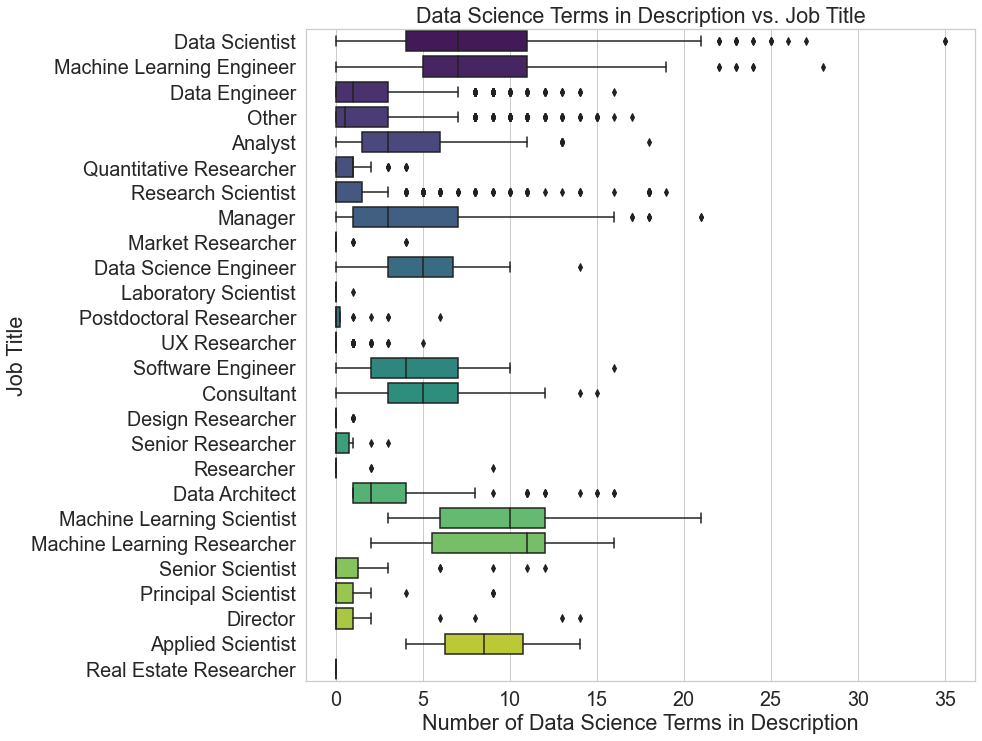

In [5]:
# examine the number of data science terms for different job titles using boxplot

plt.figure(figsize = (12, 12))
sns.boxplot(x = data['Data Science Terms Count'], y = data['Job Title'], palette = 'viridis')
plt.xlabel('Number of Data Science Terms in Description')
plt.title('Data Science Terms in Description vs. Job Title')
plt.show()

- Job titles with the largest number of data science terms in the descriptions are: 
Data Scientist, Machine Learning Engineer, Machine Learning Scientist, Machine Learning Researcher, and Applied Scientist.
- Job titles with zero or very small number of data science terms in the descriptions are: 
Market Researcher, Laboratory Scientist, UX Researcher, Design Researcher, Researcher, and Real Estate Researcher.

This raises the question: How did our job search for 'Data Scientist' positions yielded results from the second group? Is it because ‘Researcher’ has close association with ‘Scientist’ or is there some other criterion? 

In general, one of the most prevalent observations from our job searches is that a significant number of the results were practically irrelevant to the search. This is not a characteristic of the LinkedIn search engine but of all job search engines of different sites we have tried.

In addition to the above distributions, it would also be informative to find the behavior of the average number of data science terms with job title.

In [6]:
# get the mean of data science terms for each job title
ds_terms_mean = [data[data['Job Title'] == title]['Data Science Terms Count'].mean() for title in data['Job Title']]

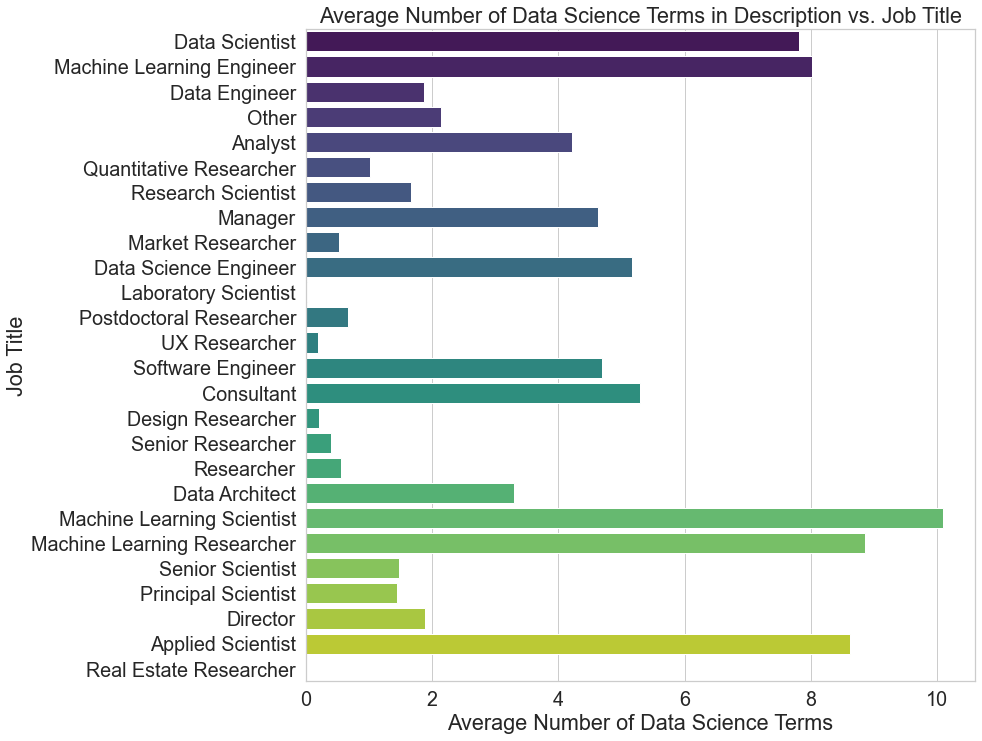

In [7]:
# plot the means

plt.figure(figsize = (12, 12))
sns.barplot(x = ds_terms_mean, y = data['Job Title'], palette = 'viridis')
plt.xlabel('Average Number of Data Science Terms')
plt.title('Average Number of Data Science Terms in Description vs. Job Title')

plt.show()

The average number of data science terms in the job description is consistent with the box plot results.

Finally, we would like to examine the histogram of the data science terms count.

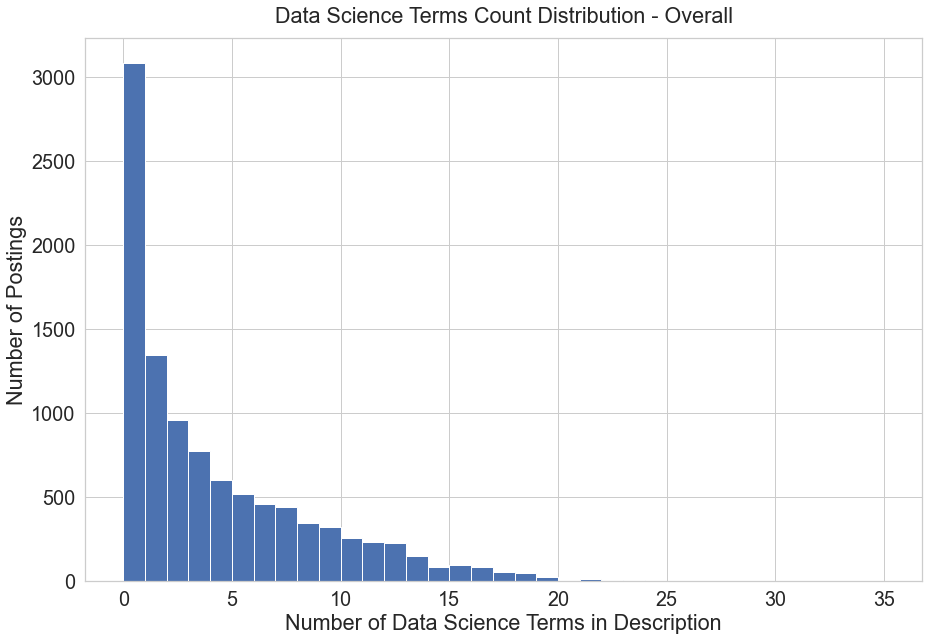

In [8]:
# when creating a histogram, for comparison with other cases it is best to set an appropriate bin size instead of number of bins
# the number of bins will be derived based on the selected bin size and values range

count_dst = data['Data Science Terms Count']

bin_size = 1
n_bins = int((count_dst.max() - count_dst.min()) // bin_size) # make sure to define it as an integer

plt.figure(figsize = (15, 10))
plt.hist(count_dst, bins = n_bins)
plt.xlabel('Number of Data Science Terms in Description')
plt.ylabel('Number of Postings')
plt.title('Data Science Terms Count Distribution - Overall', pad = 15)

plt.show()

As the histogram shows, an extremely large number of records have zero or very small number of data science terms in their description. It is therefore critical to eliminate the records which we believe to be irrelevant to our search. 

We set a threshold of three data science terms in the description as the minimum a record has to meet in order to be considered relevant. The reason for selecting three data science terms is that during scraping we have witnessed many descriptions which read along these lines: "The data engineer will be working closely with the data science team to support various data science projects ...." Clearly, this is not a Data Scientist or any closely related position and yet it has two data science terms in its description.

In [9]:
# get the title counts for all records and for the ones with few data science terms in description

# all jobs
list_titles = list(data['Job Title'].value_counts().index) # titles of all jobs
titles_count_1 = list(data['Job Title'].value_counts().values) # their count values

# titles with 2 or less data science terms
title_count_ds = data[data['Data Science Terms Count'] < 3]['Job Title'].value_counts()

In [10]:
# the two counts do not neccesarily have the same titles in the same order
# since we want to plot these two on the same plot we need to match them

# create list of zeroes with size matching the size of all job titles
titles_count_2 = [0 for _ in range(len(list_titles))]

In [11]:
# fill the correct values for the titles with few ds terms

i_1 = -1
i_2 = -1
for item_1 in list_titles:
    i_1 += 1
    i_2 = -1
    
    for item_2 in title_count_ds.index:
        i_2 += 1
        
        if item_1 == item_2:
            titles_count_2[i_1] = title_count_ds.values[i_2]

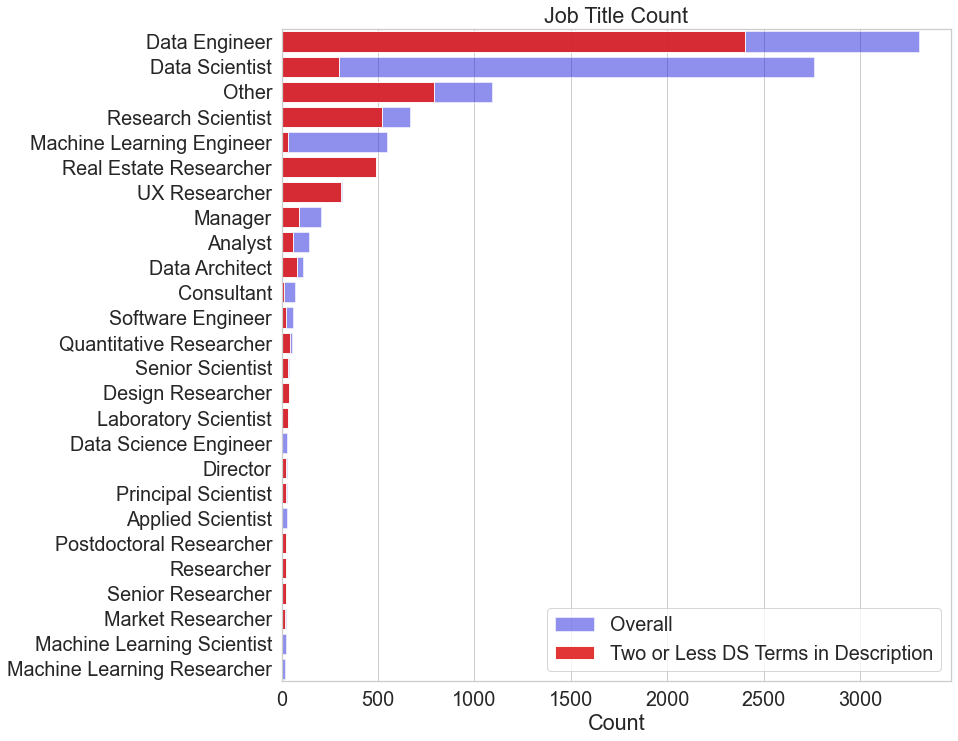

In [12]:
# plot both counts
plt.figure(figsize = (12, 12))
sns.barplot(x = titles_count_1, y = list_titles, color = 'blue', alpha = 0.5, label = 'Overall')
sns.barplot(x = titles_count_2, y = list_titles, color = 'red', alpha = 0.9, label = 'Two or Less DS Terms in Description')
plt.xlabel('Count')
plt.title('Job Title Count')

plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right')
plt.show()

As seen from the plot, a significant number of postings for some job titles fall in the category of irrelevant postings. 'Data Engineer' is, perhaps, the most extreme example since it has the largest number of postings overall and nearly 3/4 of them do not pass the relevancy test.

It is also notable that there are postings with the title of 'Data Scientist' which do not meet the data science terms count threshold. However, based on the title alone we will leave these records in the data.

Therefore, we will eliminate all postings which do not pass the relevancy threshold and have a title different from ‘Data Scientist’.

In [13]:
# set the appropriate filter for jobs with titles different from Data Scientist and having few data science terms
mask_ds = (data['Job Title'] != 'Data Scientist') & (data['Data Science Terms Count'] < 3)

# apply filter and create a new dataset, data_1
data_1 = data[~mask_ds] # elimnates all postings which satisfy the condition above
data_1.reset_index(inplace = True, drop = True)

data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5076 entries, 0 to 5075
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Job Title                 5076 non-null   object
 1   Company Name              5076 non-null   object
 2   Industry                  5076 non-null   object
 3   Job Function              5076 non-null   object
 4   Metro Area                5076 non-null   object
 5   Education-Bachelor        5076 non-null   int64 
 6   Education-Master          5076 non-null   int64 
 7   Education-Doctor          5076 non-null   int64 
 8   Minimum Experience        5076 non-null   int64 
 9   Seniority Level           5076 non-null   object
 10  Data Science Terms Count  5076 non-null   int64 
 11  Time Posted               5076 non-null   int64 
 12  Number of Applicants      5076 non-null   int64 
dtypes: int64(7), object(6)
memory usage: 515.7+ KB


After filtering the records by data science terms count the data points have been reduced two-fold from 10165 initially to 5075.

We would like to examine again the histogram of the data science terms count after filtering.

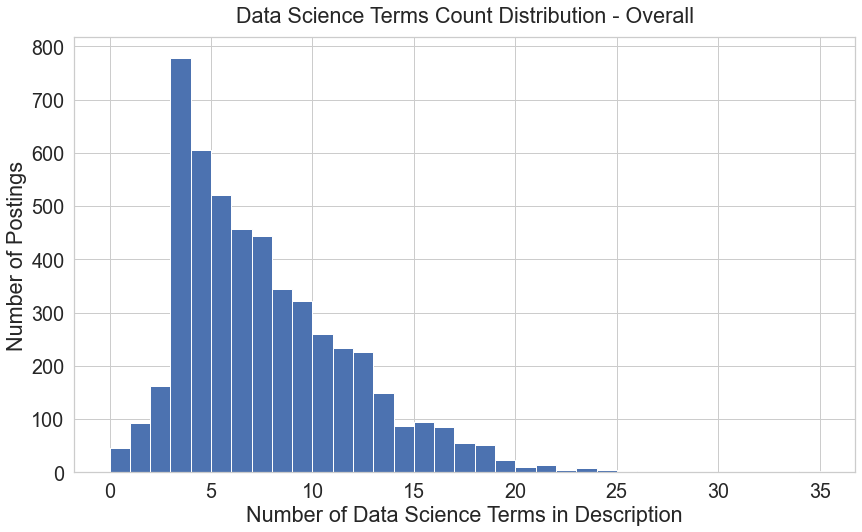

In [14]:
# plot again the distribution of data science terms
count_dst = data_1['Data Science Terms Count']

bin_size = 1
n_bins = int((count_dst.max() - count_dst.min()) // bin_size) # make sure to define it as an integer

plt.figure(figsize = (14, 8))
plt.hist(count_dst, bins = n_bins)

plt.xlabel('Number of Data Science Terms in Description')
plt.ylabel('Number of Postings')
plt.title('Data Science Terms Count Distribution - Overall', pad = 15)

plt.show()

As expected the distribution now is significantly different with the largest number of postings having three or four data science terms in their description. The remaining few records with a small number of data science terms belong to the few 'Data Scientist' positions which we discussed earlier.

In order to be able to use this feature for modeling it is more appropriate to separate the data entries into different classes with a particular range of data terms in the description. We will create a new feature 'Relevance' using the following segmentation:
- Class 1: 0-2 terms
- Class 2: 3-6 terms
- Class 3: 7-10 terms
- Class 4: 11- terms

In [15]:
# create new feature 'Relevance'

data_1['Relevance'] = 0
data_1.head()

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Relevance
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,0
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,-10,0
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,0
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,0
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,0,entry,3,1,-10,0


In [16]:
# fill its values appropriately

n_dst = 0

for i in range(len(data_1)):
    n_dst = data_1['Data Science Terms Count'][i]
    
    if n_dst < 3:
        data_1['Relevance'][i] = 1
    elif n_dst >= 3 and n_dst < 7:
        data_1['Relevance'][i] = 2
    elif n_dst >= 7 and n_dst < 11:
        data_1['Relevance'][i] = 3
    else:
        data_1['Relevance'][i] = 4

In [17]:
# check
data_1.head()

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Relevance
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,3
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,-10,1
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,2
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,2
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,0,entry,3,1,-10,2


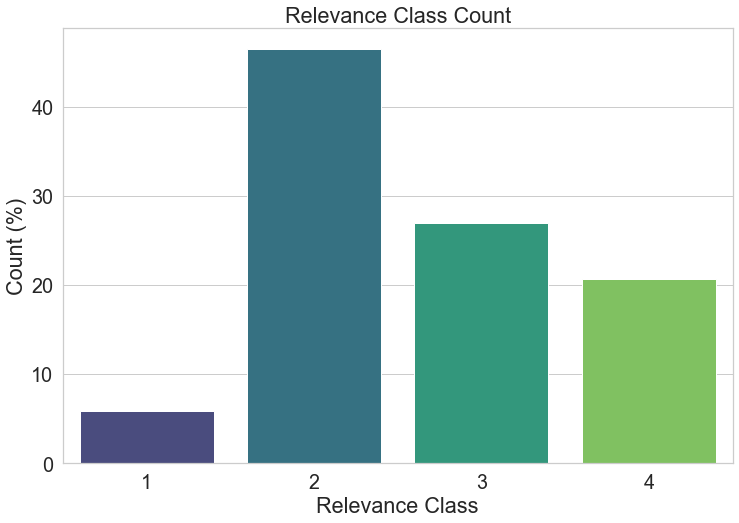

In [18]:
# get and plot 'Relevance' value count

count_relevance = data_1['Relevance'].value_counts(normalize = True) * 100

plt.figure(figsize = (12, 8))
sns.barplot(x = count_relevance.index, y = count_relevance.values, palette = 'viridis')
plt.xlabel('Relevance Class')
plt.ylabel('Count (%)')
plt.title('Relevance Class Count')
plt.show()

The resulting relevance classes count is as expected based on the data science terms histogram plotted earlier. The relevance classes 2, 3 and 4 are well represented, while class 1 accounts for only about 6% of the data.

- **Company Name**

This is another feature which can be used to filter out redundant postings. Let's examine how many different companies are in the data and their relative contribution.

In [19]:
# get 'Company Name' count as percentage
count_company = data_1['Company Name'].value_counts(normalize = True) * 100

print(round(count_company, 2))

Dice                                                                                     3.92
Amazon                                                                                   2.66
Amazon Web Services (AWS)                                                                1.95
ClearanceJobs                                                                            1.85
Harnham                                                                                  1.58
                                                                                         ... 
C4 Technical Services                                                                    0.02
Amick Brown - Cloud Technologies, SAP and Business Intelligence Staffing & Consulting    0.02
Drizly                                                                                   0.02
Texas Capital Bank                                                                       0.02
BlockFi                                                     

There are 1534 different company names. A feature with this many categorical values will create serious problems for our model. That's why we will examine the company names in more detail to see if it would be possible to reduce their number.

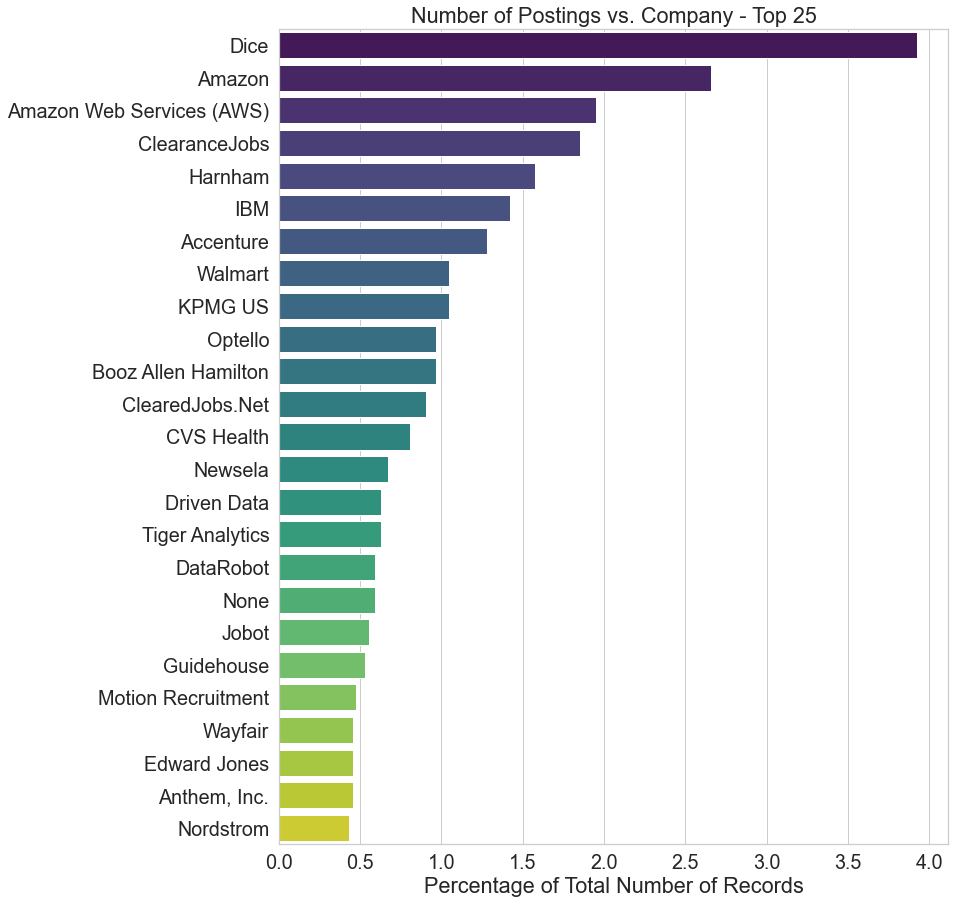

In [20]:
# plot the top 25

n_pts = 25

plt.figure(figsize = (12, 15))
sns.barplot(x = count_company.iloc[0:n_pts].values, y = count_company.iloc[0:n_pts].index, palette = 'viridis')
plt.xlabel('Percentage of Total Number of Records')
plt.title('Number of Postings vs. Company - Top ' + str(n_pts))
plt.show()

We note that Dice has the largest number of records in our data. Since it is another job search site and not a company which offers direct employment, the Dice postings are most likely redundant (duplicates of direct companies postings). Therefore, in order to avoid redundancy we will eliminate all Dice postings.

The second and third places are occupied by Amazon. Although Amazon Web Services is a part of Amazon, we will consider it as a separate entity due to the significant difference in the nature of its business. 

Among other highly represented companies we would like to note IBM, Walmart, Booz Allen Hamilton, and CVS. 

The rest of the companies in the graph is a mixture of large analytics consulting companies and staffing and recruiting companies.

In [21]:
# eliminate Dice and create a new dataset, data_2
data_2 = data_1[data_1['Company Name'] != 'Dice']
data_2.reset_index(inplace = True, drop = True)

data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4877 entries, 0 to 4876
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Job Title                 4877 non-null   object
 1   Company Name              4877 non-null   object
 2   Industry                  4877 non-null   object
 3   Job Function              4877 non-null   object
 4   Metro Area                4877 non-null   object
 5   Education-Bachelor        4877 non-null   int64 
 6   Education-Master          4877 non-null   int64 
 7   Education-Doctor          4877 non-null   int64 
 8   Minimum Experience        4877 non-null   int64 
 9   Seniority Level           4877 non-null   object
 10  Data Science Terms Count  4877 non-null   int64 
 11  Time Posted               4877 non-null   int64 
 12  Number of Applicants      4877 non-null   int64 
 13  Relevance                 4877 non-null   int64 
dtypes: int64(8), object(6)
m

By eliminating the Dice postings the number of data points has been reduced by additional 199 points - from 5076 to 4877.

We have also noticed that there are records with a company name 'None'. We would like to examine some of these records more closely to decide if the information there is valid.

In [22]:
data_2[data_2['Company Name'] == 'None'].iloc[0:10, :]

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Relevance
58,Data Scientist,None,Engineering,Full-time,CHI,0,0,0,5,entry,2,2,49,1
427,Other,None,Biotechnology,Engineering,NY,0,1,0,3,associate,4,6,200,2
658,Data Scientist,None,Internet,Engineering,NY,0,1,0,3,senior,13,3,-10,4
812,Data Scientist,None,Biotechnology,Engineering,BOS,0,0,1,0,entry,4,3,200,2
1203,Other,None,Biotechnology,Engineering,NY,0,1,0,3,associate,4,6,200,2
1248,Data Scientist,None,Computer Software,Marketing,SEA,1,1,0,6,associate,10,4,52,3
1419,Data Scientist,None,Other,Management,DC,0,1,1,5,senior,9,3,-10,3
1463,Machine Learning Engineer,None,Staffing and Recruiting,Engineering,NY,0,0,0,5,senior,4,2,200,2
1508,Machine Learning Engineer,None,Transportation,Information Technology,PHX,1,1,0,5,senior,3,2,-10,2
1645,Other,None,Other,Full-time,BOS,0,1,0,5,entry,3,4,-10,2


The information in these records seems fine. These records are most likely postings by staffing and recruiting companies which do not want to reveal the company name. So, we will keep these entries, but will replace 'None' with 'Other' for the company name.

In [23]:
# repalce 'None' with 'Other'

data_2.replace('None', 'Other', inplace = True)

Also, we would like to see if there are some duplicate company names as was the case with Amazon and Amazon AWS. Because the list of companies is too extensive, we will check only for the top 100.

In [24]:
# print the first 50

count_company = data_2['Company Name'].value_counts(normalize = True) * 100

n_pts = 50

print(round(count_company.iloc[0:n_pts], 2))

Amazon                        2.77
Amazon Web Services (AWS)     2.03
ClearanceJobs                 1.93
Harnham                       1.64
IBM                           1.48
Accenture                     1.33
Walmart                       1.09
KPMG US                       1.09
Booz Allen Hamilton           1.00
Optello                       1.00
ClearedJobs.Net               0.94
CVS Health                    0.84
Newsela                       0.70
Tiger Analytics               0.66
Driven Data                   0.66
Other                         0.62
DataRobot                     0.62
Jobot                         0.57
Guidehouse                    0.55
Motion Recruitment            0.49
Anthem, Inc.                  0.47
Edward Jones                  0.47
Wayfair                       0.47
Burtch Works                  0.45
Nordstrom                     0.45
JPMorgan Chase & Co.          0.45
Jobs via eFinancialCareers    0.43
TikTok                        0.43
Accenture Federal Se

In [25]:
# print the next 50

print(round(count_company.iloc[n_pts: 2 * n_pts], 2))

Affirm                                 0.29
Fetch Rewards, Inc.                    0.29
eBay                                   0.27
Avanade                                0.27
Enhance IT                             0.27
New Relic, Inc.                        0.27
DPR Construction                       0.27
Grid Dynamics                          0.27
Cognizant                              0.25
LivePerson                             0.25
Glassdoor                              0.25
Intelletec                             0.25
Adobe                                  0.25
Bluecore                               0.25
Fidelity Investments                   0.23
T-Mobile                               0.23
Quantitative Systems                   0.23
Aetna, a CVS Health Company            0.23
Mozilla                                0.23
Western Governors University           0.23
Infinity Consulting Solutions          0.21
Argus Media                            0.21
Grubhub                         

We notice that Aethna, which was bought recently by CVS, is listed as a separate company. We will combine these two.

In [26]:
data_2.replace('Aetna, a CVS Health Company', 'CVS Health', inplace = True)

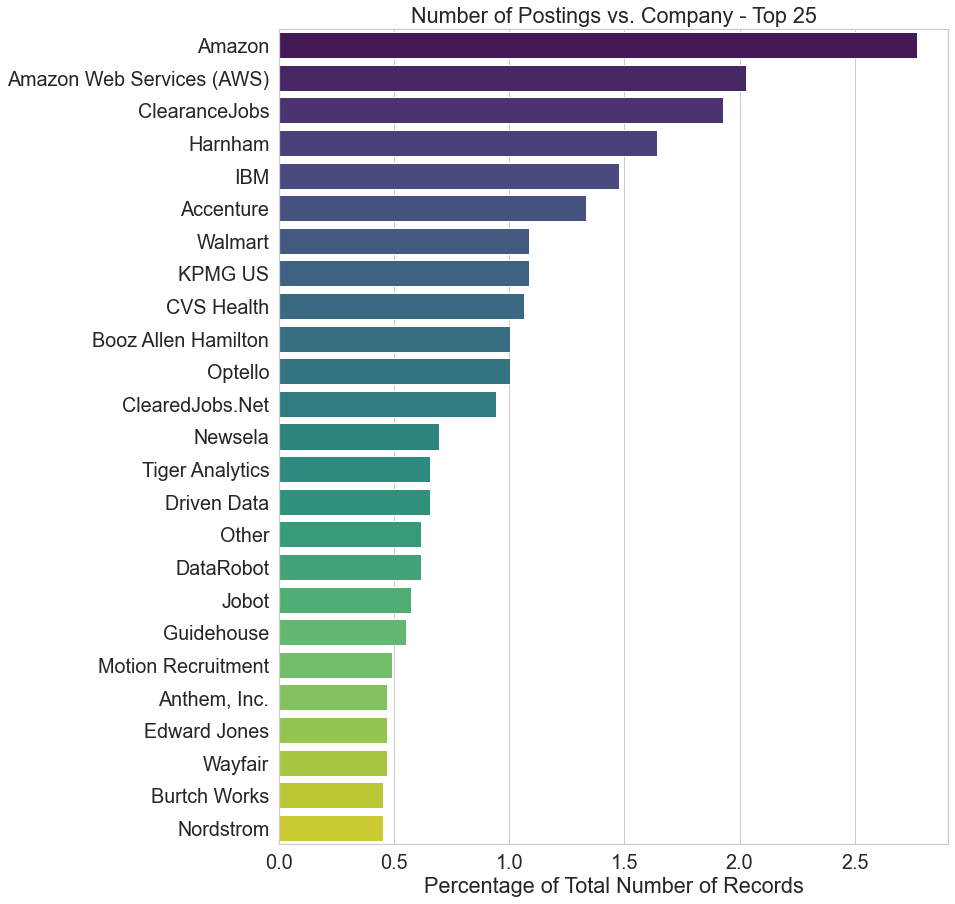

In [27]:
# plot the top 25 entries in the company count again

count_company = data_2['Company Name'].value_counts(normalize = True) * 100

n_pts = 25

plt.figure(figsize = (12, 15))
sns.barplot(x = count_company.iloc[0:n_pts].values, y = count_company.iloc[0:n_pts].index, palette = 'viridis')
plt.xlabel('Percentage of Total Number of Records')
plt.title('Number of Postings vs. Company - Top ' + str(n_pts))
plt.show()

Let's examine next the number of companies above and below the 0.1% threshold, and their contributions to the data.

In [28]:
# print the companies above the 0.1% threshold

print('Number of companies above the 0.1% threshold: ', len(count_company[count_company.values >= 0.1]))
print('Percentage of all records: ', round(sum(count_company[count_company.values >= 0.1].values), 2))
print('\n')
print(round(count_company[count_company.values >= 0.1], 2))

Number of companies above the 0.1% threshold:  199
Percentage of all records:  55.4


Amazon                                     2.77
Amazon Web Services (AWS)                  2.03
ClearanceJobs                              1.93
Harnham                                    1.64
IBM                                        1.48
                                           ... 
Pluralsight                                0.10
System1                                    0.10
General Dynamics Information Technology    0.10
Equifax                                    0.10
Avail Medsystems                           0.10
Name: Company Name, Length: 199, dtype: float64


In [29]:
# print the companies below the 0.1% threshold

print('Number of companies below the 0.1% threshold: ', len(count_company[count_company.values < 0.1]))
print('Percentage of all records: ', round(sum(count_company[count_company.values < 0.1].values), 2))
print('\n')
print(round(count_company[count_company.values < 0.1], 2))

Number of companies below the 0.1% threshold:  1333
Percentage of all records:  44.6


Octave Bioscience                            0.08
Verusen                                      0.08
Zdaly                                        0.08
PA Consulting                                0.08
iRobot                                       0.08
                                             ... 
Drizly                                       0.02
Texas Capital Bank                           0.02
Madison-Davis, LLC - Executive Recruiting    0.02
ICX Media, Inc.                              0.02
BlockFi                                      0.02
Name: Company Name, Length: 1333, dtype: float64


There are 199 companies above the 0.1% threshold which represent 55% of all records. The number of companies below the 0.1% threshold is 1333 and represent 45% of all remaining data. Because of this, it would not be appropriate to combine companies below the 0.1% threshold. This leaves us with a rather large number of companies which makes this feature not suitable for using in the data modeling.

- **'Minimum Experience'**

Another feature which deserves our attention is 'Minimum Experience' which might provide valuable differentiation between different postings.

In [30]:
# print the value count for different years of experience
print('Years  Count')
print(data_2['Minimum Experience'].value_counts())

Years  Count
0      1324
2       845
3       828
5       793
4       339
1       244
6       137
10      121
7       101
8        66
15       12
20       10
200      10
50        8
9         7
25        6
12        5
55        3
160       3
18        3
13        2
180       2
148       2
45        1
89        1
40        1
329       1
22        1
75        1
Name: Minimum Experience, dtype: int64


Two types of values here deserve our attention. 
- The first is the 0 years of experience. These values can be attributed to either experience not being mentioned in the description or that the search pattern did not match the phrase used in the text.
- The second is the large values (e.g. 20, 50, 160 etc.) which are clearly not related to the experience required. These most likely refer to the number of years of the company being in business or having a team with a certain number of combined years of experience.

Both of these types of values will be replaced with the average value per seniority level.

In [31]:
# create a list for 'Seniority Level'
list_seniority = data_2['Seniority Level'].value_counts().index
list_seniority

Index(['senior', 'entry', 'associate'], dtype='object')

In [32]:
# fill 'Minimum Experience' values accordingly

for item in list_seniority:
    # create a filter with 'Minimum Experience' of 0 or greater than 10
    mask_exp = (data_2['Seniority Level'] == item) & (data_2['Minimum Experience'] == 0) | (data_2['Minimum Experience'] > 10)
    
    min_exp = np.array(data_2['Minimum Experience'][~mask_exp]) # get the rest of experience values
    min_exp = min_exp.mean()
    
    # we want to assign integer values as minimum experience - check if min_exp < 0.6 and assign 1
    if min_exp < 0.6:
        data_2['Minimum Experience'][mask_exp] = 1
    else:
        data_2['Minimum Experience'][mask_exp] = int(round(min_exp, 0))

In [33]:
# check the new count
count_exp = data_2['Minimum Experience'].value_counts()
print(count_exp)

3     1879
2      845
5      793
4      684
1      244
6      137
10     121
7      101
8       66
9        7
Name: Minimum Experience, dtype: int64


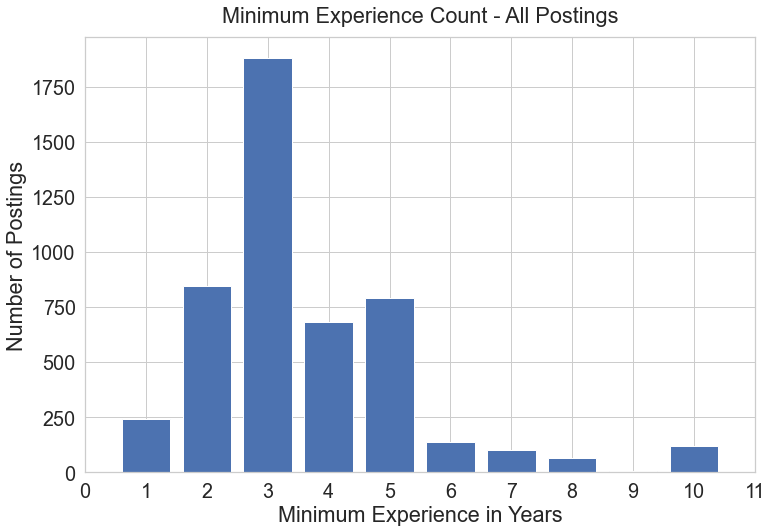

In [34]:
# visualize with a barplot

d_x = 1
x_min = 0
x_max = count_exp.index.max() + d_x
x_ticks = np.arange(x_min, x_max + d_x, d_x)


plt.figure(figsize = (12, 8))
plt.bar(count_exp.index, count_exp.values)
plt.xticks(x_ticks)
plt.xlabel('Minimum Experience in Years')
plt.ylabel('Number of Postings')
plt.title('Minimum Experience Count - All Postings', pad = 15)

plt.show()

The most often occuring minimum experience values are three years, followed by two, five, and four years.

It would be interesting to see if there are differences in minimum experience depending on seniority level.

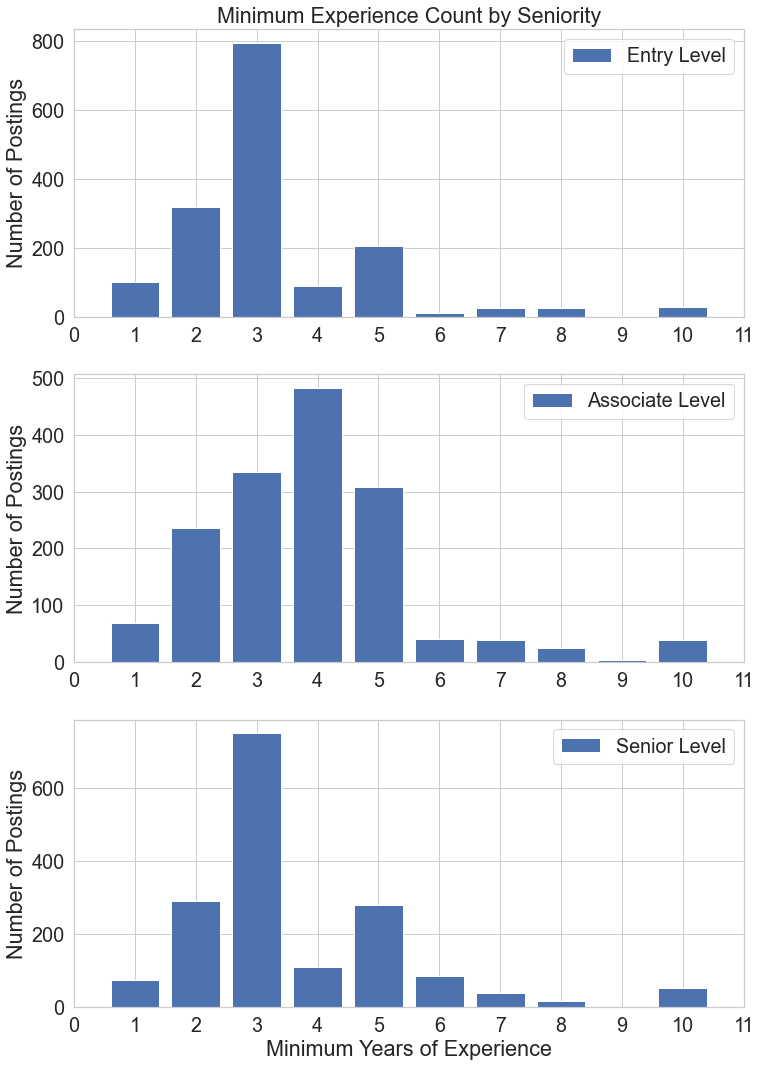

In [35]:
# entry level
count_exp_1 = data_2[data_2['Seniority Level'] == 'entry']['Minimum Experience'].value_counts()
# associate level
count_exp_2 = data_2[data_2['Seniority Level'] == 'associate']['Minimum Experience'].value_counts()
# senior level
count_exp_3 = data_2[data_2['Seniority Level'] == 'senior']['Minimum Experience'].value_counts()

fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharey = False)

axes[0].bar(count_exp_1.index, count_exp_1.values, label = 'Entry Level')
axes[0].set_xlim(x_min, x_max)
axes[0].set_xticks(x_ticks)
axes[0].set(ylabel = 'Number of Postings')
axes[0].set(title = 'Minimum Experience Count by Seniority')
axes[0].legend()

axes[1].bar(count_exp_2.index, count_exp_2.values, label = 'Associate Level')
axes[1].set_xlim(x_min, x_max)
axes[1].set_xticks(x_ticks)
axes[1].set(ylabel = 'Number of Postings')
axes[1].legend()

axes[2].bar(count_exp_3.index, count_exp_3.values, label = 'Senior Level')
axes[2].set_xlim(x_min, x_max)
axes[2].set_xticks(x_ticks)
axes[2].set(xlabel = 'Minimum Years of Experience')
axes[2].set(ylabel = 'Number of Postings')
axes[2].legend()

plt.show()

The minimum experience pattern for Associate level is certainly different from that for Entry and Senior level positions. However, Entry and Senior level positions have very similar minimum experience patterns which is not natural to expect. Additionally, the experience beyond five years varies significantly and seemingly randomly for different seniority levels with ten years having in two cases the highest count. This is most certainly not expected and cannot be explained rationally - most notably, one would not expect to have a minimum experience requirement greater than five years for Entry level positions.

There are a couple of reasons we could think of that could be responsible for these results.

In many job descriptions, years of experience vary depending on the level of education - for example 5 years for a BS degree, 3 years for an MS degree and 1 year for a PhD degree.
In addition, some descriptions include different experience requirements for different skills - for example different programing languages, machine learning vs. data analytics experience, etc. Thus, selecting the minimum from a collection of different experience requirements as we have done would not capture accurately the actual requirement for the position.

**Overall, the minimum experience values extracted from the scraped data are ambiguous and might be misleading in distinguishing between positions with different seniority levels and other different features. That’s why we will not include ‘Minimum Experience’ in our data modeling.**

## II.2 Separating Data into Datasets with Known and Unknown Number of Applicants

Here we will work with the two data features which are most important for our project: 1) 'Number of Applicants'; 2) 'Time Posted'.

In [36]:
data_2.head()

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Relevance
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,3
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,-10,1
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,2
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,2
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,3,entry,3,1,-10,2


In [37]:
# get 'Number of Applicants' count as percentage
count_applicants = data_2['Number of Applicants'].value_counts(normalize = True) * 100

print(round(count_applicants, 2))

-10     68.98
 200     5.88
 32      0.70
 26      0.68
 25      0.66
        ...  
 188     0.02
 180     0.02
 172     0.02
 164     0.02
 199     0.02
Name: Number of Applicants, Length: 171, dtype: float64


In 69% of the data the number of applicants is undetermined. It is only known that there are 24 or less applicants for these positions.

Therefore, we would like to separate data into two subsets - data_a with known number of applicants and data_b with unknown number of applicants - and to examine the differences between them in terms of essential features.

In [38]:
# select known - data_a
data_a = data_2[data_2['Number of Applicants'] != -10].copy()
data_a.reset_index(inplace = True, drop = True)

# select unknown - data_b
data_b = data_2[data_2['Number of Applicants'] == -10].copy()
data_b.reset_index(inplace = True, drop = True)

In [39]:
# get info - data_a
data_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Job Title                 1513 non-null   object
 1   Company Name              1513 non-null   object
 2   Industry                  1513 non-null   object
 3   Job Function              1513 non-null   object
 4   Metro Area                1513 non-null   object
 5   Education-Bachelor        1513 non-null   int64 
 6   Education-Master          1513 non-null   int64 
 7   Education-Doctor          1513 non-null   int64 
 8   Minimum Experience        1513 non-null   int64 
 9   Seniority Level           1513 non-null   object
 10  Data Science Terms Count  1513 non-null   int64 
 11  Time Posted               1513 non-null   int64 
 12  Number of Applicants      1513 non-null   int64 
 13  Relevance                 1513 non-null   int64 
dtypes: int64(8), object(6)
m

In [40]:
data_a.head()

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Relevance
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,3
1,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,2
2,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,2
3,Data Scientist,Georgia-Pacific LLC,Construction,Engineering,ATL,0,1,0,2,entry,7,2,27,3
4,Data Scientist,Mailchimp,Internet,Engineering,ATL,0,0,0,2,entry,6,5,192,2


In [41]:
# get info - data_b
data_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3364 entries, 0 to 3363
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Job Title                 3364 non-null   object
 1   Company Name              3364 non-null   object
 2   Industry                  3364 non-null   object
 3   Job Function              3364 non-null   object
 4   Metro Area                3364 non-null   object
 5   Education-Bachelor        3364 non-null   int64 
 6   Education-Master          3364 non-null   int64 
 7   Education-Doctor          3364 non-null   int64 
 8   Minimum Experience        3364 non-null   int64 
 9   Seniority Level           3364 non-null   object
 10  Data Science Terms Count  3364 non-null   int64 
 11  Time Posted               3364 non-null   int64 
 12  Number of Applicants      3364 non-null   int64 
 13  Relevance                 3364 non-null   int64 
dtypes: int64(8), object(6)
m

In [42]:
data_b.head()

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Relevance
0,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,-10,1
1,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,3,entry,3,1,-10,2
2,Data Scientist,Leidos,Defense,Engineering,ATL,1,0,0,1,entry,10,1,-10,3
3,Data Scientist,Vanderlande,Staffing and Recruiting,Information Technology,ATL,1,0,0,4,entry,4,1,-10,2
4,Data Scientist,Search Discovery,Marketing and Advertising,Engineering,ATL,0,0,0,2,entry,7,1,-10,3


The dataset with known number of applicants, data_a, has 1513 data points; the dataset with unknown number of applicants, data_b, consists of 3364 data points.

Let's compare the features value distributions for the two datasets.

- **Data A and Data B Comparison: 'Time Posted'**

It is natural to expect that the 'Time Posted' values would be distributed differently for the two datasets. One would expect that for the data with the number of applicants capped at 25 the time posted is mostly composed of small values - most likely 1 day. That's why we would like to compare those two.

In [43]:
# data_a

# check the new count
count_posted_a = data_a['Time Posted'].value_counts()
print(count_posted_a)

4    285
1    272
5    268
3    226
6    183
2    163
7    113
0      3
Name: Time Posted, dtype: int64


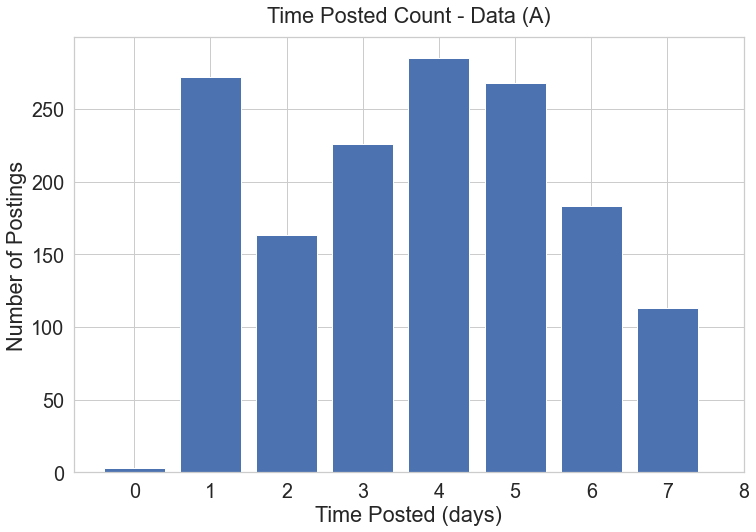

In [44]:
# visualize with a barplot

d_x = 1
x_min = 0
x_max = count_posted_a.index.max() + d_x
x_ticks = np.arange(x_min, x_max + d_x, d_x)


plt.figure(figsize = (12, 8))
plt.bar(count_posted_a.index, count_posted_a.values)
plt.xticks(x_ticks)
plt.xlabel('Time Posted (days)')
plt.ylabel('Number of Postings')
plt.title('Time Posted Count - Data (A)', pad = 15)

plt.show()

There are few records with a value of 0. The rest of the 'Time Posted' values for Data (A) vary in the range 100-300 with 4, 2, and 5 days having the highest counts and 7 days having the lowest count.

In [45]:
# data_b

# check the new count
count_posted_b = data_b['Time Posted'].value_counts()
print(count_posted_b)

1    966
3    477
4    451
5    420
2    420
6    363
7    239
0     28
Name: Time Posted, dtype: int64


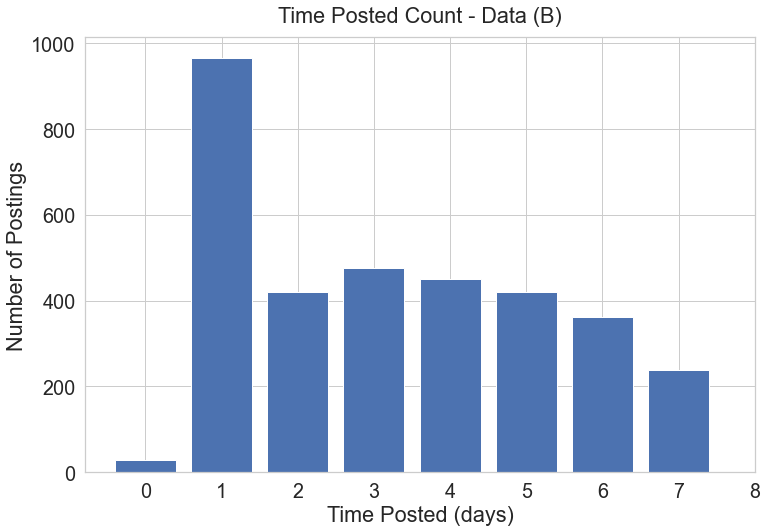

In [46]:
# visualize with a barplot

d_x = 1
x_min = 0
x_max = count_posted_b.index.max() + d_x
x_ticks = np.arange(x_min, x_max + d_x, d_x)


plt.figure(figsize = (12, 8))
plt.bar(count_posted_b.index, count_posted_b.values)
plt.xticks(x_ticks)
plt.xlabel('Time Posted (days)')
plt.ylabel('Number of Postings')
plt.title('Time Posted Count - Data (B)', pad = 15)

plt.show()

As expected, the 1 day records have the highest count in Data (B). However, there is still a significant number of records which have been posted for more than one day and yet have not reached 25 applicants.

- **Data A and Data B Comparison: 'Job Title'**

In [47]:
# define a function to plot the value count of different features for any dataset

data_feat = 'Job Title'
data_name = 'Data (A)' # data_name will be used as a legend in the plot
plt_pts = 25

fig_size_x = 12
fig_size_y = 15
legend_box_x = 1.01 
legend_box_y = 0.06

x_max = 100
d_x = 10

# define function
def plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x, legend_box_x, legend_box_y):
    
    plt.figure(figsize = (fig_size_x, fig_size_y))
    sns.barplot(x = count_feat.iloc[0:plt_pts].values, y = count_feat.iloc[0:plt_pts].index, palette = 'viridis', label = data_name)
    plt.xlim(0, x_max)
    plt.xticks(np.arange(0, x_max + d_x , d_x))
    plt.xlabel('Percentage of Total Number of Records')
    plt.title('Number of Postings with ' + data_feat + ' as Percentage of All Postings', pad = 20)
    plt.legend(bbox_to_anchor = (legend_box_x, legend_box_y))
    plt.show()

In [48]:
# get and print feature value count for data_a

data = data_a
data_feat = 'Job Title'
count_feat = data[data_feat].value_counts(normalize = True) * 100

print(count_feat)
print('\n')
print(data_feat + ' - total number of values: ', len(count_feat))

Data Scientist                 60.674157
Machine Learning Engineer      13.483146
Data Engineer                  13.417052
Other                           3.899537
Research Scientist              2.709848
Analyst                         1.784534
Manager                         1.586252
Consultant                      0.396563
Machine Learning Researcher     0.396563
Data Science Engineer           0.264375
Quantitative Researcher         0.264375
Machine Learning Scientist      0.264375
Software Engineer               0.264375
Applied Scientist               0.198282
Principal Scientist             0.132188
Market Researcher               0.132188
Researcher                      0.066094
UX Researcher                   0.066094
Name: Job Title, dtype: float64


Job Title - total number of values:  18


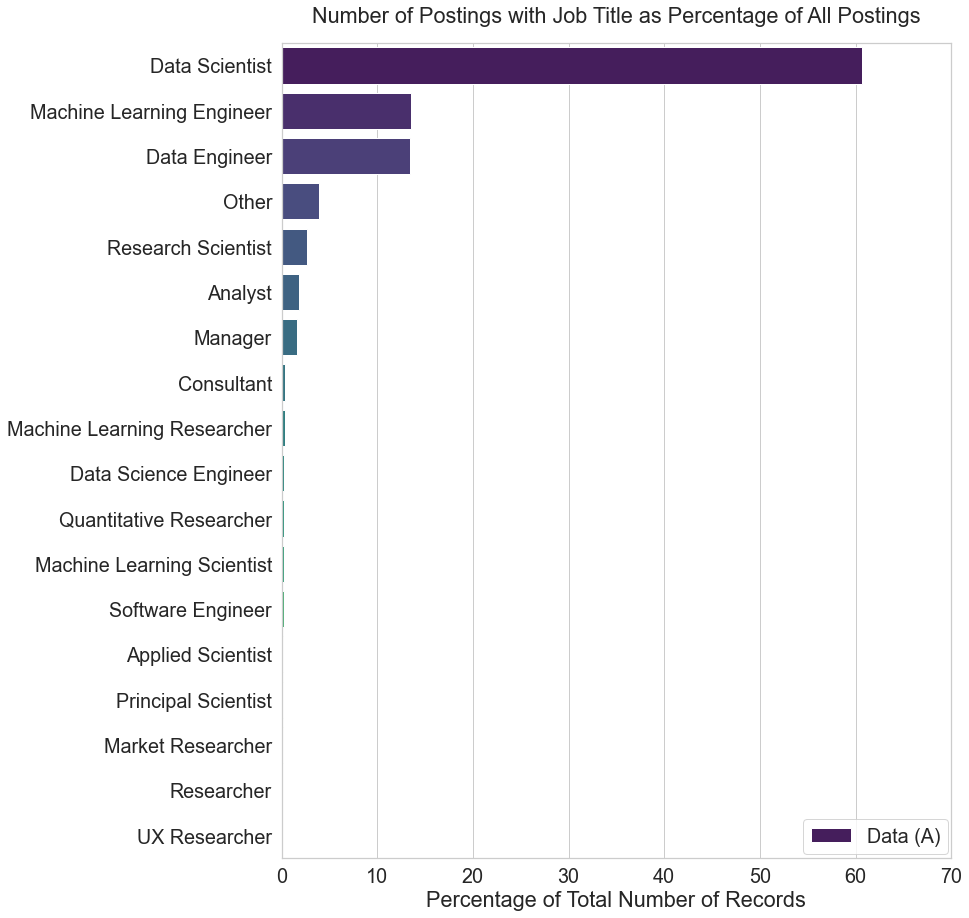

In [49]:
# plot all
plt_pts = len(count_feat)
x_max = 70
d_x = 10
plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x, legend_box_x, legend_box_y)

In [50]:
# get and print 'Job Title' value count for data_b

data = data_b

count_feat = data[data_feat].value_counts(normalize = True) * 100

print(count_feat)
print('\n')
print(data_feat + ' - total number of values: ', len(count_feat))

Data Scientist                 51.843044
Data Engineer                  19.084423
Machine Learning Engineer       8.590963
Other                           6.956005
Research Scientist              3.121284
Manager                         2.645660
Analyst                         1.605232
Consultant                      1.456599
Data Architect                  1.040428
Software Engineer               0.980975
Applied Scientist               0.683710
Data Science Engineer           0.535077
Machine Learning Scientist      0.475624
Machine Learning Researcher     0.297265
Senior Scientist                0.178359
Director                        0.118906
Quantitative Researcher         0.118906
UX Researcher                   0.089180
Postdoctoral Researcher         0.089180
Principal Scientist             0.059453
Senior Researcher               0.029727
Name: Job Title, dtype: float64


Job Title - total number of values:  21


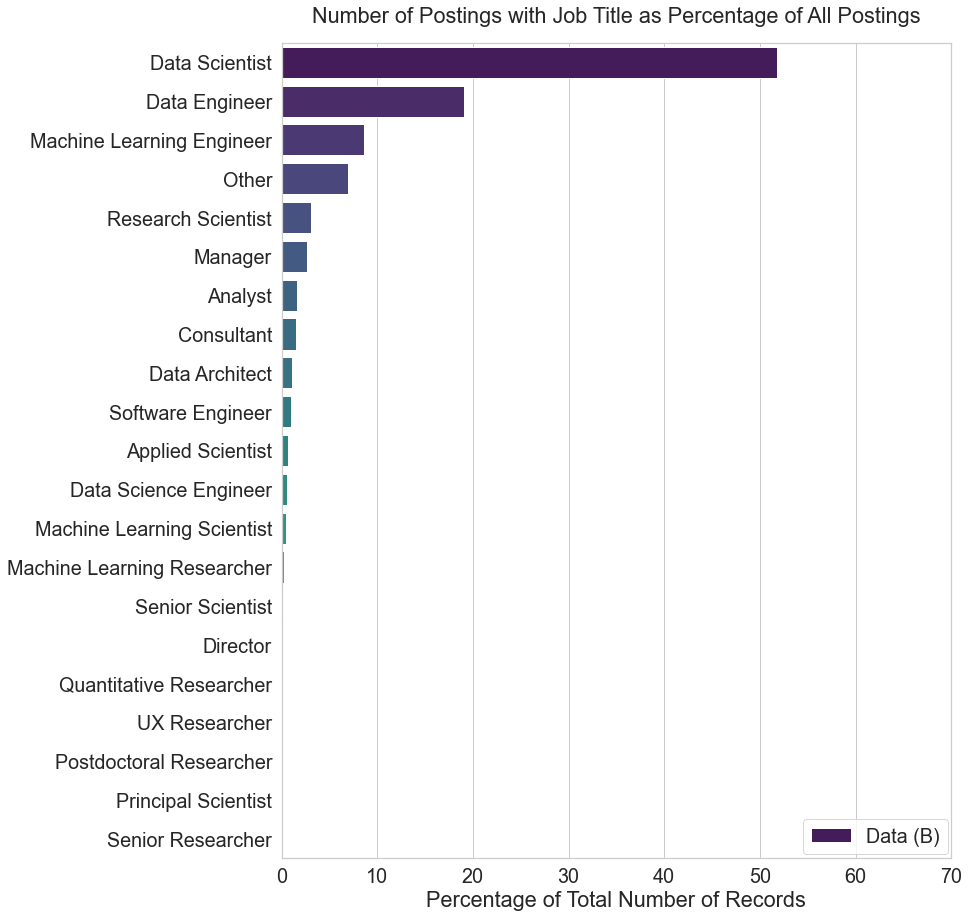

In [51]:
# plot all
plt_pts = len(count_feat)
data_name = 'Data (B)'
plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x, legend_box_x, legend_box_y)

- **Data A and Data B Comparison: 'Company Name'**

In [52]:
# get and print feature value count for data_a

data = data_a
data_feat = 'Company Name'
count_feat = data[data_feat].value_counts(normalize = True) * 100

print(count_feat)
print('\n')
print(data_feat + ' - total number of values: ', len(count_feat))

Harnham                       2.974223
Burtch Works                  1.321877
Walmart                       1.321877
CVS Health                    1.189689
TikTok                        1.057502
                                ...   
Catalina USA                  0.066094
Jobs via eFinancialCareers    0.066094
Merck                         0.066094
Edison Energy                 0.066094
Bind Benefits                 0.066094
Name: Company Name, Length: 756, dtype: float64


Company Name - total number of values:  756


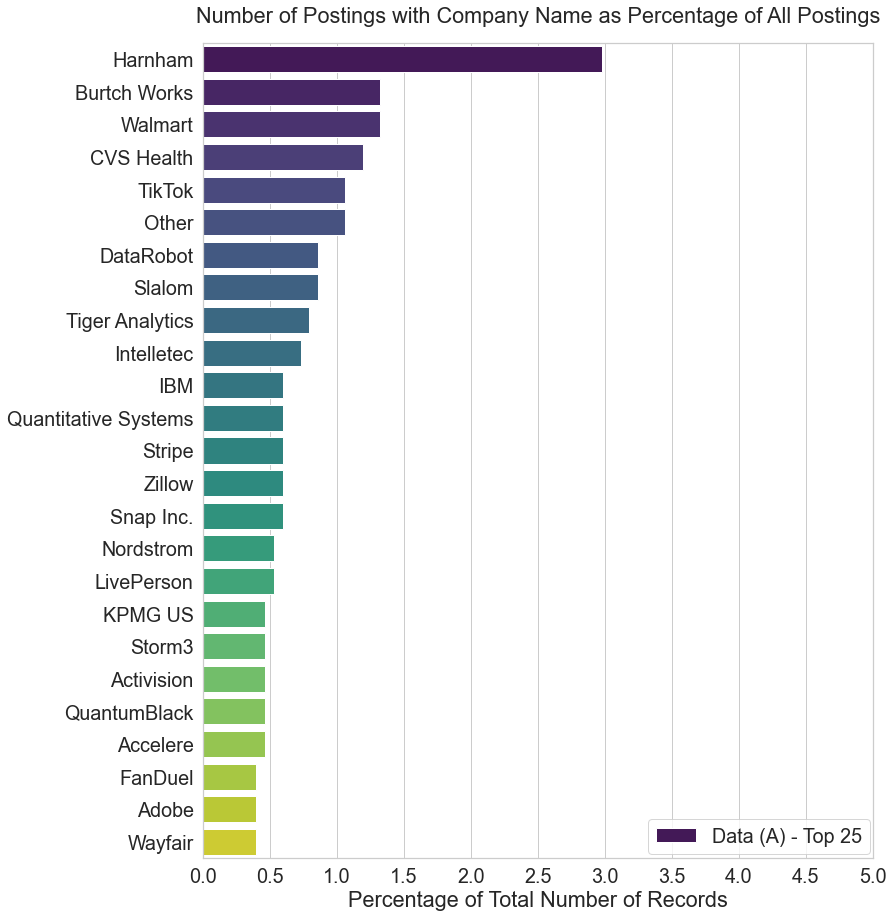

In [53]:
# plot top 25 only
plt_pts = 25

data_name = 'Data (A) - Top 25'

x_max = 5
d_x = 0.5
plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x, legend_box_x, legend_box_y)

In [54]:
# get and print feature value count for data_b

data = data_b

count_feat = data[data_feat].value_counts(normalize = True) * 100

print(count_feat)
print('\n')
print(data_feat + ' - total number of values: ', len(count_feat))

Amazon                               3.834721
Amazon Web Services (AWS)            2.913199
ClearanceJobs                        2.794293
IBM                                  1.872771
Accenture                            1.783591
                                       ...   
Age of Learning, Inc.                0.029727
Echodyne                             0.029727
KAR Global                           0.029727
Swift Strategic Solutions Inc        0.029727
University of Southern California    0.029727
Name: Company Name, Length: 1089, dtype: float64


Company Name - total number of values:  1089


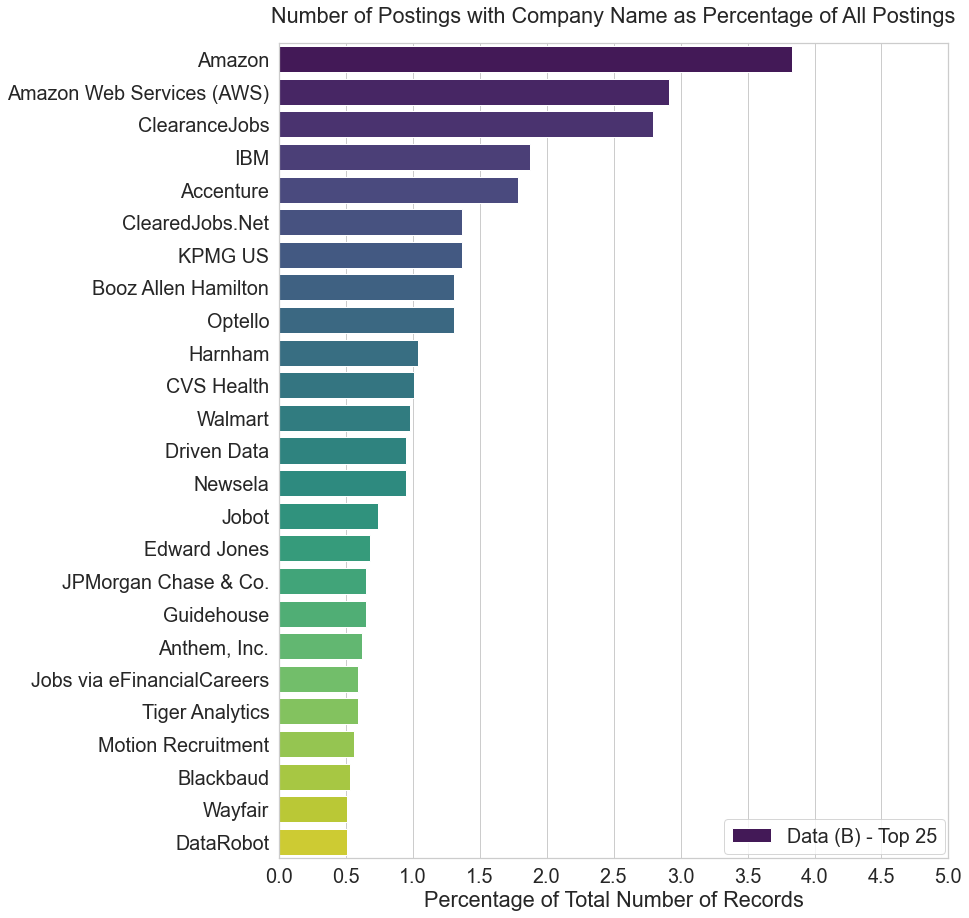

In [55]:
# plot top 25 only

data_name = 'Data (B) - Top 25'

x_max = 5
d_x = 0.5
plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x, legend_box_x, legend_box_y)

- **Data A and Data B Comparison: 'Industry'**

In [56]:
# get and print feature value count for data_a

data = data_a
data_feat = 'Industry'
count_feat = data[data_feat].value_counts(normalize = True) * 100

print(count_feat)
print('\n')
print(data_feat + ' - total number of values: ', len(count_feat))

Financial Services                     13.879709
Marketing and Advertising              13.152677
Internet                               12.822208
Computer Software                       7.204230
Health Care                             6.675479
Management Consulting                   4.626570
Biotechnology                           4.428288
Staffing and Recruiting                 4.230007
Information Technology and Services     3.965631
Insurance                               2.842036
Retail                                  2.115003
Banking                                 2.115003
Other                                   2.048909
Automotive                              1.850628
Manufacturing                           1.784534
Defense                                 1.784534
Network Security                        1.718440
Research                                1.321877
Telecommunications                      1.057502
Wellness and Fitness                    0.925314
Transportation      

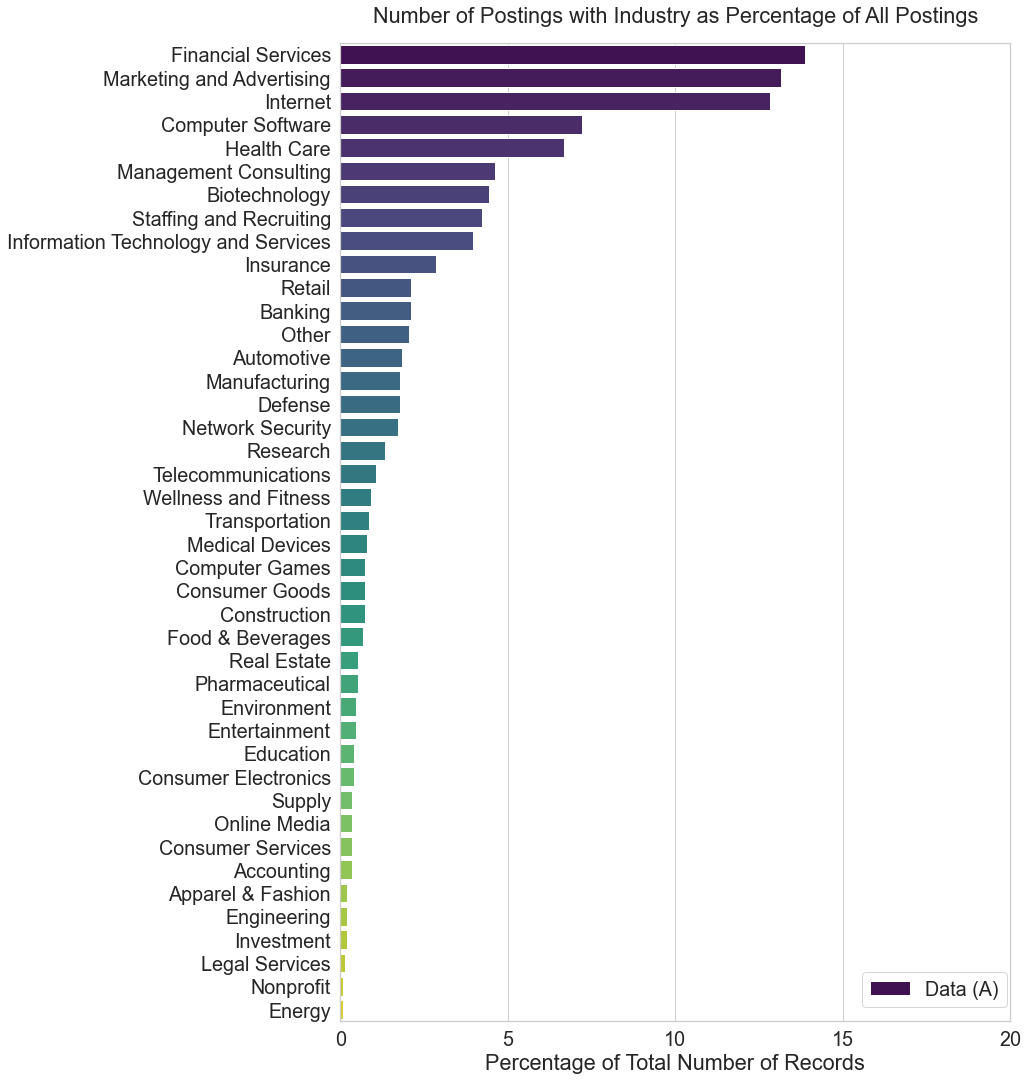

In [57]:
# plot all

data_name = 'Data (A)'

fig_size_y = 18
x_max = 20
d_x = 5

plt_pts = len(count_feat)
plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x, legend_box_x, legend_box_y)

In [58]:
# get and print feature value count for data_b

data = data_b

count_feat = data[data_feat].value_counts(normalize = True) * 100

print(count_feat)
print('\n')
print(data_feat + ' - total number of values: ', len(count_feat))

Financial Services                     19.530321
Internet                               16.676576
Marketing and Advertising              10.790725
Health Care                             7.193817
Defense                                 6.450654
Computer Software                       4.518430
Management Consulting                   4.280618
Staffing and Recruiting                 3.210464
Biotechnology                           2.883472
Banking                                 2.734839
Insurance                               2.675386
Information Technology and Services     2.021403
Network Security                        1.813317
Education                               1.753864
Telecommunications                      1.634958
Manufacturing                           1.575505
Research                                1.189061
Other                                   0.951249
Construction                            0.862069
Automotive                              0.743163
Transportation      

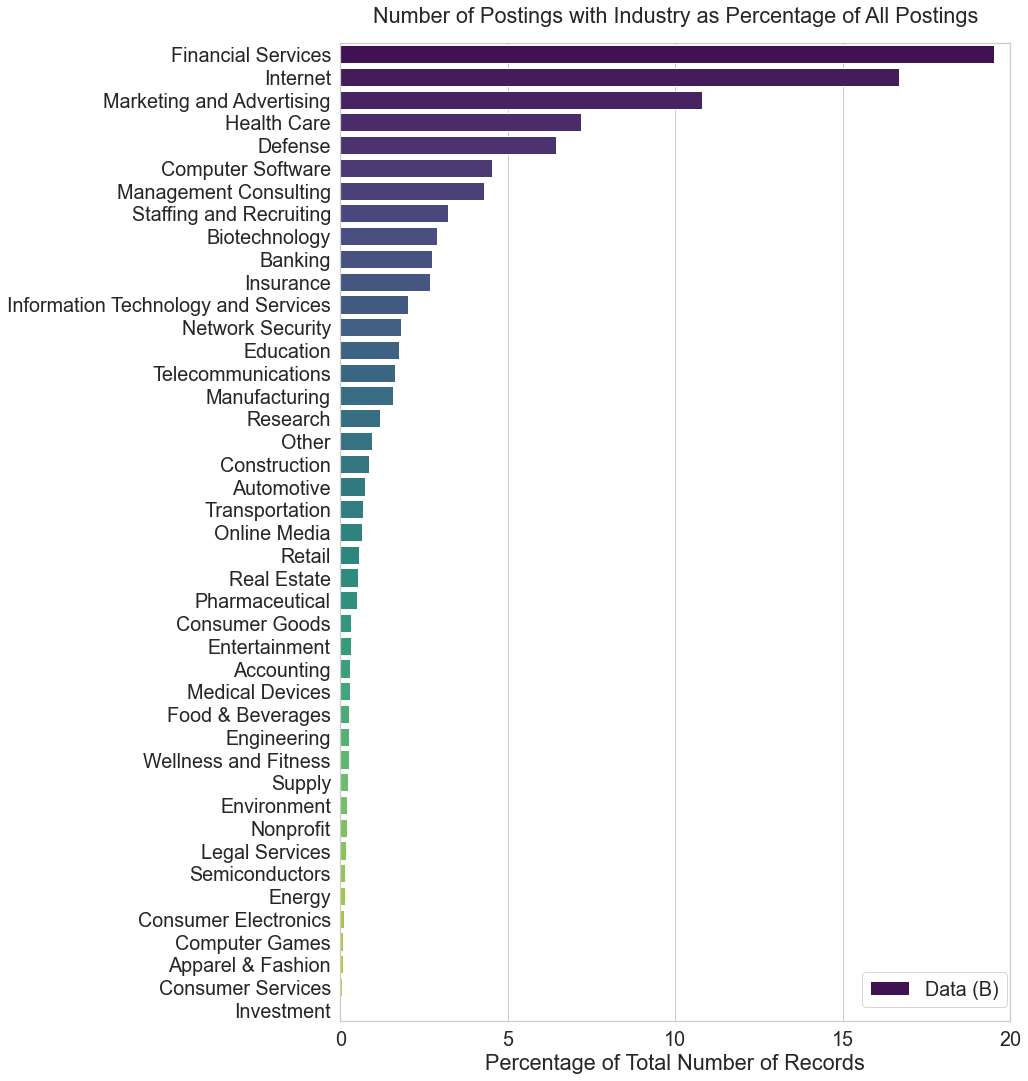

In [59]:
# plot all

data_name = 'Data (B)'
plt_pts = len(count_feat)

plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x, legend_box_x, legend_box_y)

- **Data A and Data B Comparison: 'Metro Area'**

In [60]:
# get and print feature value count for data_a

data = data_a
data_feat = 'Metro Area'
count_feat = data[data_feat].value_counts(normalize = True) * 100

print(count_feat)
print('\n')
print(data_feat + ' - total number of values: ', len(count_feat))

SF     20.356907
NY     17.514871
BOS    11.368143
LA      7.468605
CHI     7.468605
DC      6.609385
SEA     6.543291
ATL     5.089227
DAL     4.230007
AUS     4.163913
HOU     2.445473
SD      1.718440
POR     1.652346
PHI     1.454065
PHX     1.123596
NC      0.793126
Name: Metro Area, dtype: float64


Metro Area - total number of values:  16


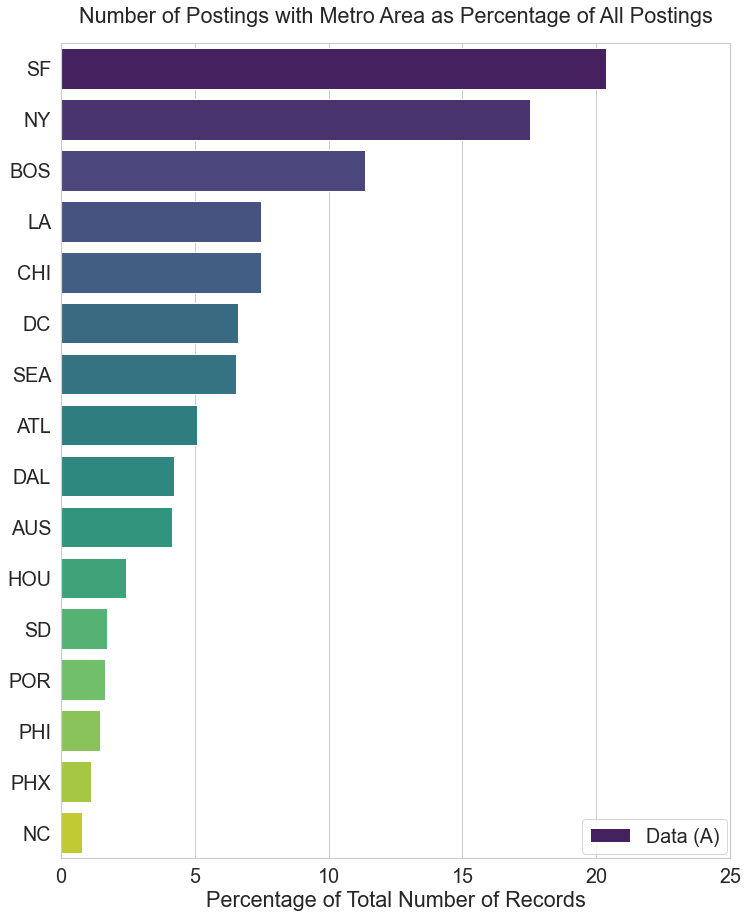

In [61]:
# plot all

data_name = 'Data (A)'

fig_size_y = 15
x_max = 25
d_x = 5

plt_pts = len(count_feat)
plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x, legend_box_x, legend_box_y)

In [62]:
# get and print feature value count for data_b

data = data_b

count_feat = data[data_feat].value_counts(normalize = True) * 100

print(count_feat)
print('\n')
print(data_feat + ' - total number of values: ', len(count_feat))

DC     18.995244
NY     11.087990
SF      9.571938
BOS     9.036861
SEA     8.531510
CHI     7.134364
ATL     6.093936
LA      5.826397
DAL     4.458977
PHI     3.596908
PHX     3.596908
AUS     3.240190
SD      2.586207
HOU     2.437574
POR     2.288942
NC      1.516052
Name: Metro Area, dtype: float64


Metro Area - total number of values:  16


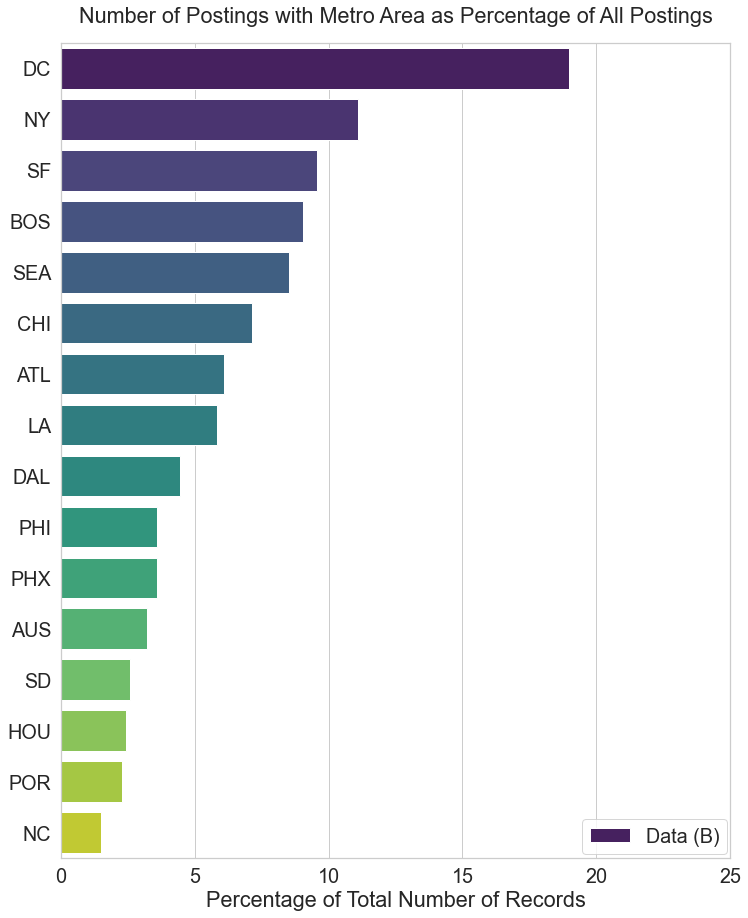

In [63]:
# plot all

data_name = 'Data (B)'


plt_pts = len(count_feat)
plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x, legend_box_x, legend_box_y)

- **Data A and Data B Comparison: 'Seniority Level'**

In [64]:
# get and print feature value count for data_a

data = data_a
data_feat = 'Seniority Level'
count_feat = data[data_feat].value_counts(normalize = True) * 100

print(count_feat)
print('\n')
print(data_feat + ' - total number of values: ', len(count_feat))

senior       41.308658
entry        37.078652
associate    21.612690
Name: Seniority Level, dtype: float64


Seniority Level - total number of values:  3


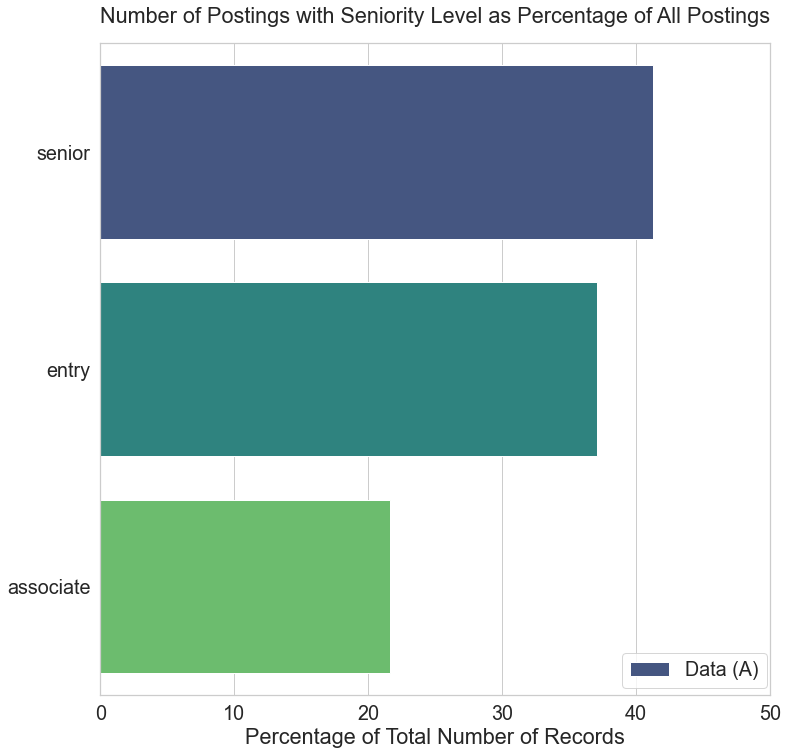

In [65]:
# plot all

data_name = 'Data (A)'

fig_size_y = 12
x_max = 50
d_x = 10

legend_box_y = 0.08

plt_pts = len(count_feat)
plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x, legend_box_x, legend_box_y)

In [66]:
# get and print feature value count for data_b

data = data_b

count_feat = data[data_feat].value_counts(normalize = True) * 100

print(count_feat)
print('\n')
print(data_feat + ' - total number of values: ', len(count_feat))

associate    37.098692
senior       32.104637
entry        30.796671
Name: Seniority Level, dtype: float64


Seniority Level - total number of values:  3


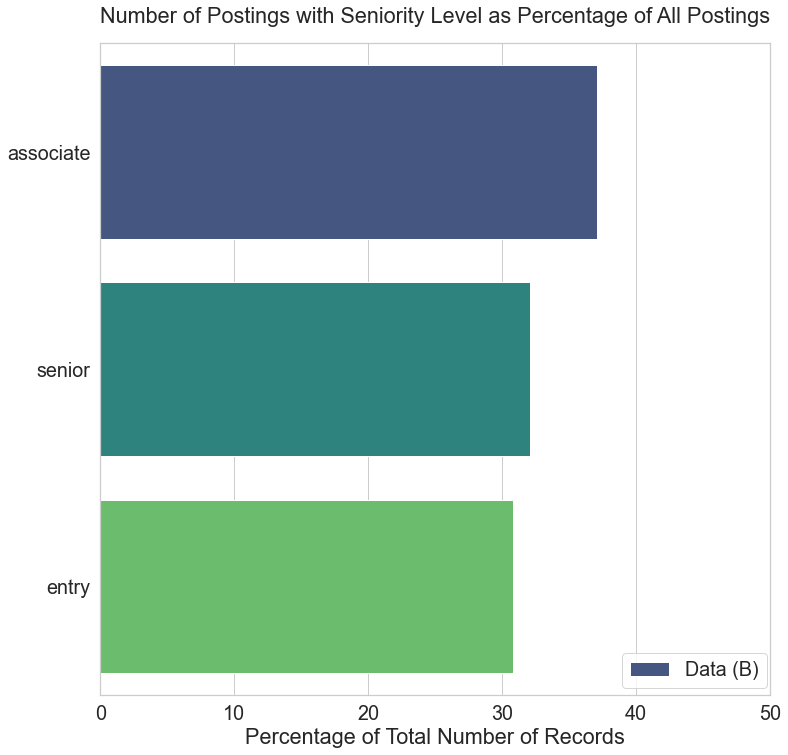

In [67]:
# plot all

data_name = 'Data (B)'

plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x, legend_box_x, legend_box_y)

- **Data A and Data B Comparison: 'Education'**

In [68]:
# get the degrees count for different seniority levels - data_a

edu_data = []

list_edu = ['Education-Bachelor', 'Education-Master', 'Education-Doctor']
list_seniority = ['entry', 'associate', 'senior'] # change the list order for more logical plot

for item_1 in list_edu:
    
    for item_2 in list_seniority:
        edu_data.append({"Seniority Level" : item_2, 
                         "Degree" : item_1, 
                         "Count" : sum(data_a[data_a['Seniority Level'] == item_2][item_1])})

In [69]:
# create corresponding data frame

df_edu_count = pd.DataFrame(edu_data)
df_edu_count

,Seniority Level,Degree,Count
0,entry,Education-Bachelor,268
1,associate,Education-Bachelor,122
2,senior,Education-Bachelor,227
3,entry,Education-Master,331
4,associate,Education-Master,172
5,senior,Education-Master,322
6,entry,Education-Doctor,175
7,associate,Education-Doctor,132
8,senior,Education-Doctor,243


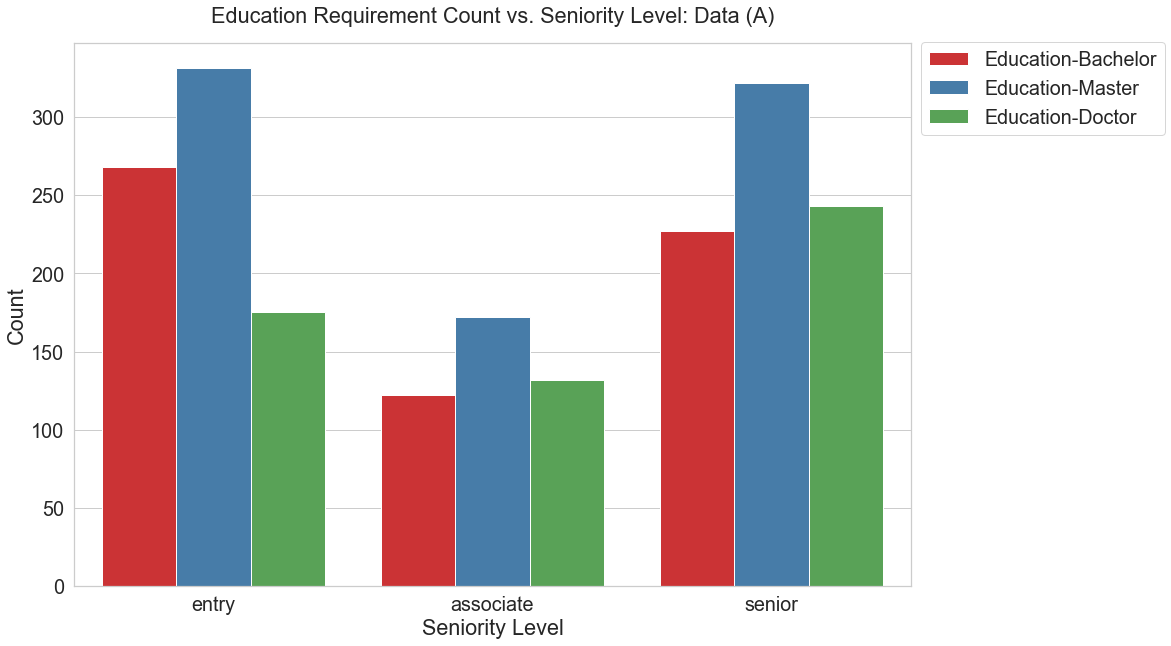

In [70]:
# plot
plt.figure(figsize = (15, 10))

sns.barplot(x = 'Seniority Level', y = 'Count', data = df_edu_count, hue = 'Degree', palette = 'Set1')
plt.title('Education Requirement Count vs. Seniority Level: Data (A)', pad = 20)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.915), ncol=1)
plt.show()

In [71]:
# get the degrees count for different seniority levels - data_b

edu_data = []


for item_1 in list_edu:
    
    for item_2 in list_seniority:
        edu_data.append({"Seniority Level" : item_2, 
                         "Degree" : item_1, 
                         "Count" : sum(data_b[data_b['Seniority Level'] == item_2][item_1])})

In [72]:
# create corresponding data frame

df_edu_count = pd.DataFrame(edu_data)
df_edu_count

,Seniority Level,Degree,Count
0,entry,Education-Bachelor,565
1,associate,Education-Bachelor,584
2,senior,Education-Bachelor,521
3,entry,Education-Master,538
4,associate,Education-Master,674
5,senior,Education-Master,591
6,entry,Education-Doctor,295
7,associate,Education-Doctor,392
8,senior,Education-Doctor,481


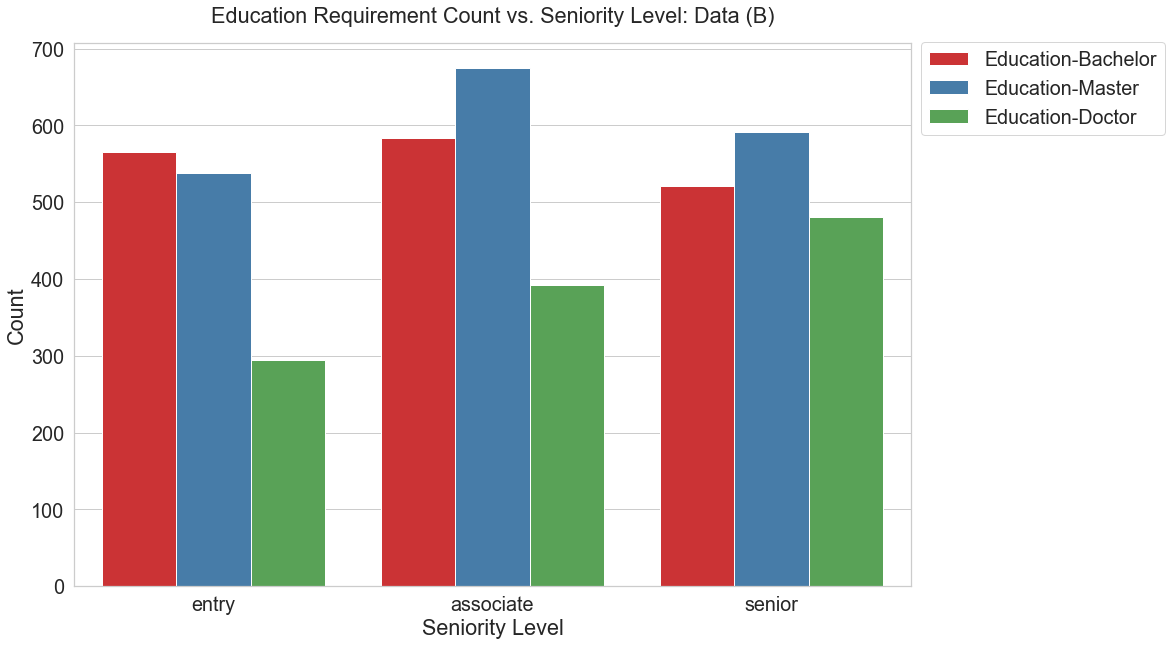

In [73]:
# plot
plt.figure(figsize = (15, 10))

sns.barplot(x = 'Seniority Level', y = 'Count', data = df_edu_count, hue = 'Degree', palette = 'Set1')
plt.title('Education Requirement Count vs. Seniority Level: Data (B)', pad = 20)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.915), ncol=1)
plt.show()

## II.3 Saving Data for Modeling

We are going to save both Data (A) and Data (B) for modeling. However, we will save only the features which are relevant for the future work.

In [74]:
data_a.head()

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Relevance
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,3
1,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,2
2,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,2
3,Data Scientist,Georgia-Pacific LLC,Construction,Engineering,ATL,0,1,0,2,entry,7,2,27,3
4,Data Scientist,Mailchimp,Internet,Engineering,ATL,0,0,0,2,entry,6,5,192,2


In [75]:
data_a.columns

Index(['Job Title', 'Company Name', 'Industry', 'Job Function', 'Metro Area',
       'Education-Bachelor', 'Education-Master', 'Education-Doctor',
       'Minimum Experience', 'Seniority Level', 'Data Science Terms Count',
       'Time Posted', 'Number of Applicants', 'Relevance'],
      dtype='object')

From the data features 'Company Name' and 'Minimum Experience' are not helpful for modeling for the reasons discussed earlier. In addition, 'Data Science Terms Count' was used to derive the categorical feature 'Relevance' which will be used in the modeling. Thus, these three features will not be saved in the modeling data.

In [76]:
# select the relevant features we will continue to work with
save_features = ['Job Title', 'Industry', 'Job Function', 'Metro Area', 'Education-Bachelor', 
                 'Education-Master', 'Education-Doctor', 'Seniority Level', 'Relevance', 
                 'Time Posted', 'Number of Applicants']

In [77]:
# save data_a

save_data = data_a[save_features]
file_save = file_read + 'a_model.xlsx'

save_data.to_excel(file_save, index = False)

In [78]:
# save data_b

save_data = data_b[save_features]
file_save = file_read + 'b_model.xlsx'

save_data.to_excel(file_save, index = False)